Populating the interactive namespace from numpy and matplotlib


/home/mario/anaconda3/envs/computer_vision/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


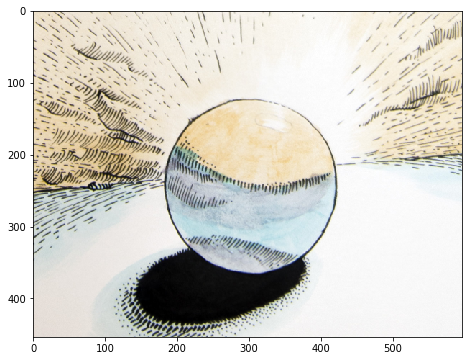

In [1]:
from utils import im_read, show_img, gpyramid, resize_to
import os
import numpy as np
import time

seed = int((time.time()*1e6)%1e6)
np.random.seed(seed)

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

default_files_path = "./files"
target_names = ['giant', 'hat_bis', 'rabbit', 'duck', 'test', 'shark', 'train',
                'donut', 'teacup', 'hat', 'crow', 'sphere', 'hand', 'helmet',
                'dino' ]
source_styles = ['comics.png', 'orange_aqua.png', 'fragments.png',
                 'paint_noob.png', 'victor.png', 'dreamy.png']

lpe_channels = ['lse.png', 'ld12e.png', 'rendered.png', 'lde.png', 'l_dde.png']

def stack_lpe_channels(lpe_channels_path):
    global lpe_channels
    paths = [ os.path.join(lpe_channels_path,lpe_channel) for lpe_channel in lpe_channels ]
    # Take only rgb in any case
    lpe_channels_list = [ im_read(path)[:,:,:3] for path in paths ]
    lpe_stack = lpe_channels_list[0]
    for i in range(1,len(lpe_channels_list)):
        lpe_stack = np.dstack((lpe_stack,lpe_channels_list[i]))
    return lpe_stack

i = 0
target_path = os.path.join(default_files_path,target_names[i])
B_lpe = stack_lpe_channels(target_path)

sphere_index = 11
source_path = os.path.join(default_files_path,target_names[sphere_index])
A_lpe = stack_lpe_channels(source_path)

# crop to fit
B_lpe = B_lpe[:A_lpe.shape[0],:A_lpe.shape[1]]

s = 0
style_path = os.path.join(source_path,source_styles[s])
A_style = im_read(style_path)[:,:,:3]

B_style = np.random.randint(0,high=255,size=A_style.shape, dtype=A_style.dtype)
#B_style = np.zeros(A_style.shape)


A = np.dstack((A_style,A_lpe))
B = np.dstack((B_style,B_lpe))

pyramid_ratio = 2
pyramid_levels = 4

A_gp=gpyramid(A,downscale=pyramid_ratio, max_levels = pyramid_levels )
B_gp=gpyramid(B,downscale=pyramid_ratio, max_levels = pyramid_levels )

show_img(A_style)

#!make

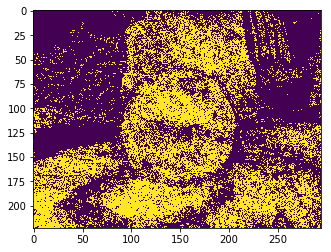

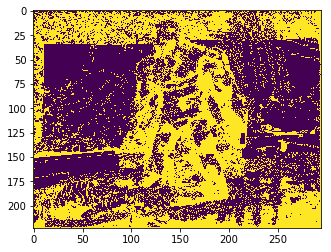

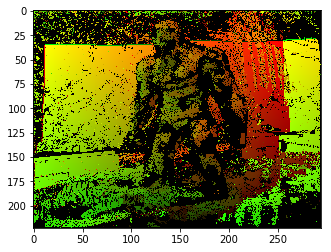

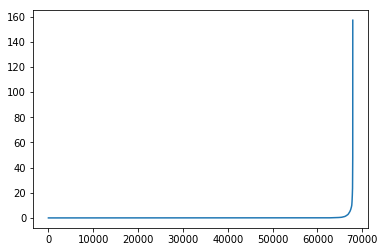

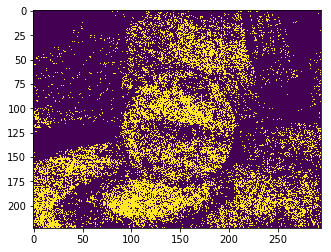

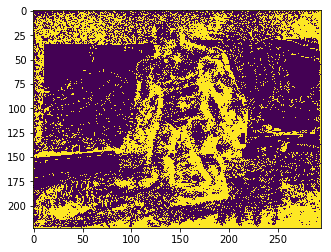

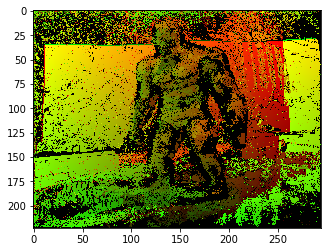

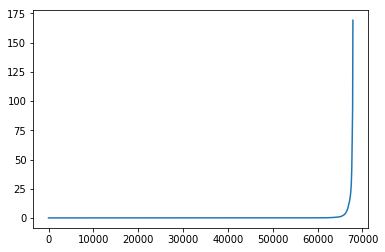

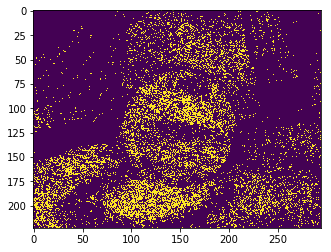

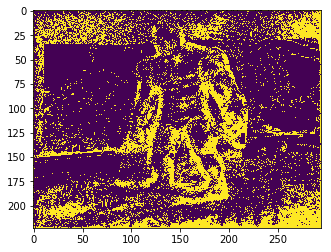

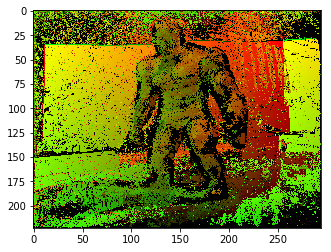

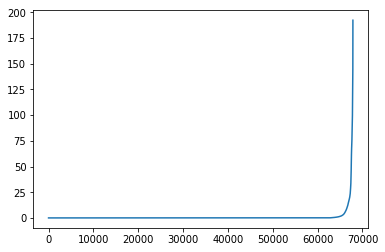

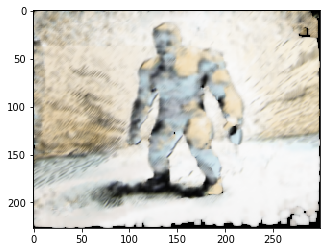

CPU times: user 9.1 s, sys: 2.86 s, total: 12 s
Wall time: 7.72 s


In [45]:

%%time
from patchmatch_reversed import reversed_nnf_approx, reconstruction
import matplotlib.pyplot as plt

def nnf_shape(A,B,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    return (h_nnf,w_nnf,3)

def compute_use_map(A,B,inv_nnf):
    h,w = inv_nnf.shape[:2]
    use_map = np.zeros(B.shape[:2])
    for i in range(h):
        for j in range(w):
            nnf_i,nnf_j = int(inv_nnf[i,j,0]), int(inv_nnf[i,j,1])
            use_map[nnf_i,nnf_j] += 1.0
    return use_map

def uniform_step(A,B,inv_nnf,mask_A,mask_B,real_nnf):
    use_map = compute_use_map(A,B,inv_nnf)
    w_map = np.zeros(B.shape[:2])
    h,w = inv_nnf.shape[:2]
    for i in range(h):
        for j in range(w):
            # if it is masked it is already assinged
            if mask_A[i,j] == 0.0:
                continue
            nnf_i,nnf_j,weight =int(inv_nnf[i,j,0]),int(inv_nnf[i,j,1]),inv_nnf[i,j,2]            
            usage = use_map[nnf_i,nnf_j] 
            # usage >= 1
            # toss a biased coin (Bernulli)
            p = 1.0/(usage)
            toss = np.random.rand()
            # keeping mostly less used
            if toss < p:
                # mask patches
                mask_B[nnf_i,nnf_j] = 0.0
                mask_A[i,j] = 0.0
                # keep track of the error at this step
                w_map[nnf_i,nnf_j] = weight
                # assign to the real_nnf for final reconstruction
                real_nnf[nnf_i,nnf_j,0] = i 
                real_nnf[nnf_i,nnf_j,1] = j
    return w_map
                
def uniform(A,B,patch_size,match_iterations=5):
        # at the beginnning all patches are available
    mask_A = np.ones(nnf_shape(A,B,patch_size)[:2])
    mask_B = np.ones(nnf_shape(B,A,patch_size)[:2])
    real_nnf = np.zeros(nnf_shape(B,A,patch_size))
    
    # first iteration
    mu1 = 0.0
    mu2 = 1.0
    inv_nnf = np.zeros(nnf_shape(A,B,patch_size))
    inv_nnf = reversed_nnf_approx(A,B,inv_nnf,mask_A,mask_B,patch_size,match_iterations,mu1,mu2)
    w_map = uniform_step(A,B,inv_nnf,mask_A,mask_B,real_nnf)
    inv_nnf = reversed_nnf_approx(A,B,inv_nnf,mask_A,mask_B,patch_size,match_iterations,mu1,mu2)
    uniform_step(A,B,inv_nnf,mask_A,mask_B,real_nnf)
    show_img(mask_A)
    show_img(mask_B)
    show_img(real_nnf)
    plt.plot(sort(w_map.flatten()))
    inv_nnf = reversed_nnf_approx(A,B,inv_nnf,mask_A,mask_B,patch_size,match_iterations,mu1,mu2)
    w_map = uniform_step(A,B,inv_nnf,mask_A,mask_B,real_nnf)
    show_img(mask_A)
    show_img(mask_B)
    show_img(real_nnf)
    plt.plot(sort(w_map.flatten()))
    inv_nnf = reversed_nnf_approx(A,B,inv_nnf,mask_A,mask_B,patch_size,match_iterations,mu1,mu2)
    w_map = uniform_step(A,B,inv_nnf,mask_A,mask_B,real_nnf)
    show_img(mask_A)
    show_img(mask_B)
    show_img(real_nnf)
    plt.plot(sort(w_map.flatten()))
    rec = reconstruction(B,A,real_nnf,patch_size)
    show_img(rec[:,:,:3])
    
                    
                    

# first level
l = 1
patch_size = 5
A = A_gp[l]
B = B_gp[l]
uniform(A,B,patch_size)

#reconstruct = True
#nnf = np.zeros(nnf_shape( A, B, patch_size ))
#rec = nnf_approx( A, B, nnf, patch_size, iterations, mu1, mu2, nnf_initialized, reconstruct )
#uniform_step(A, B, nnf)


Populating the interactive namespace from numpy and matplotlib


/home/mario/anaconda3/envs/computer_vision/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rec']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


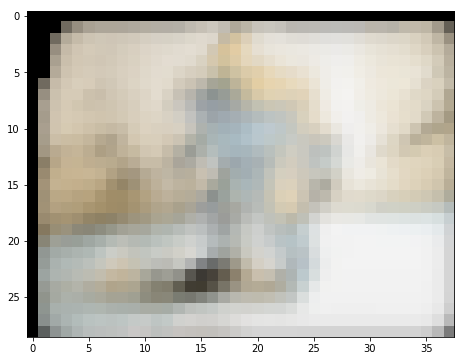

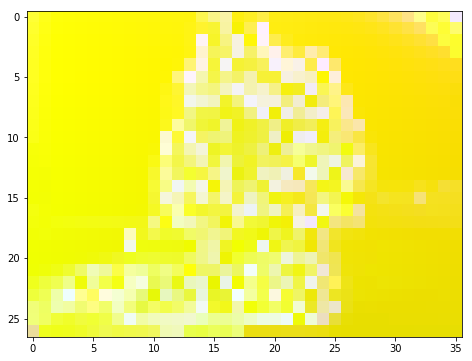

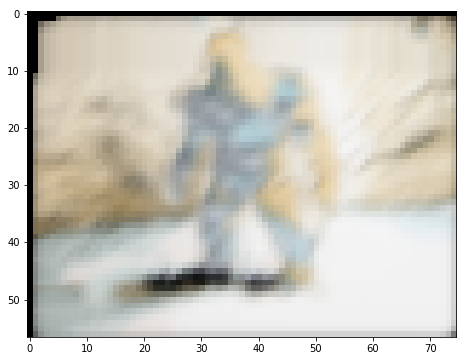

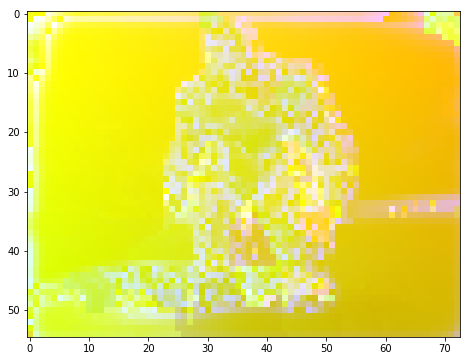

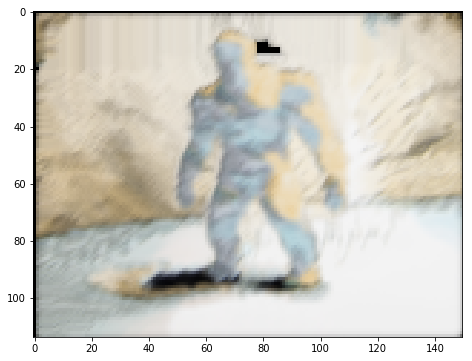

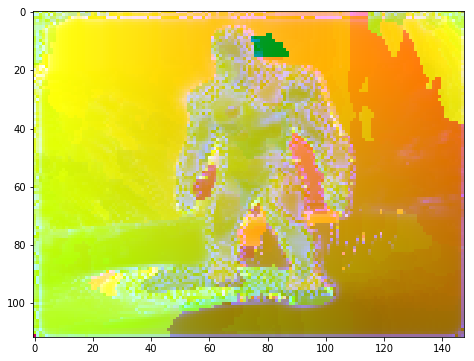

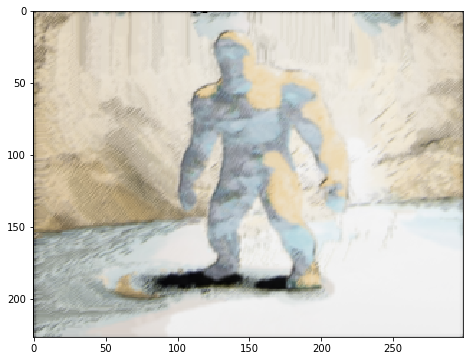

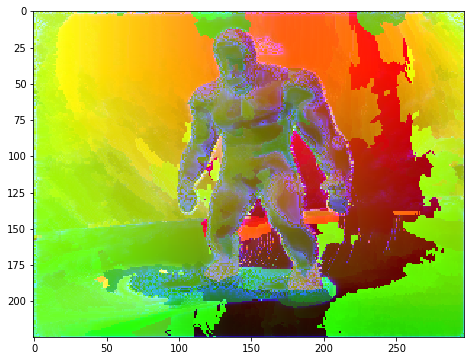

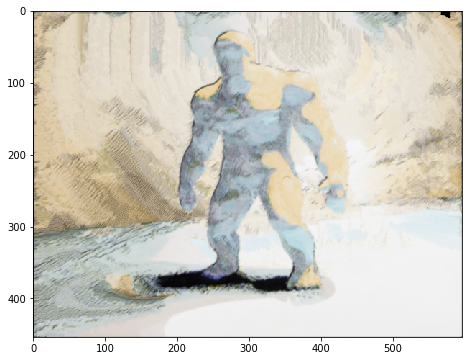

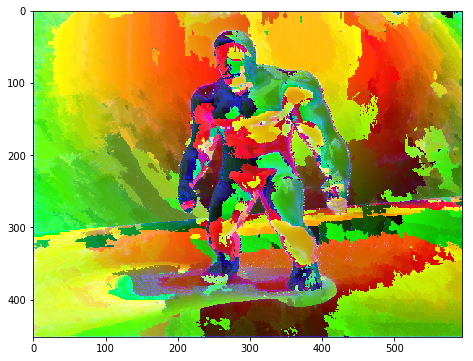

CPU times: user 15 s, sys: 3.13 s, total: 18.2 s
Wall time: 13.7 s


In [3]:
%%time
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

from patchmatch import nnf_approx

def nnf_shape(A,B,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    return (h_nnf,w_nnf,3)

# first level
l = 4
patch_size = 3
iterations = 10
mu1 = 0.0
mu2 = 1.0
nnf_initialized = False
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, True )
show_img(rec[:,:,:3])
show_img(nnf)

# second level
l = l-1
h1,w1,c=B_gp[l].shape
rec_next = resize_to(rec[:,:,:],[h1,w1,c])
mu1 = 0.1
mu2 = 2.0
nnf_initialized = False
iterations = 5
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
B_gp[l][:,:,:3] = rec_next[:,:,:3]
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, True )
show_img(rec[:,:,:3])
show_img(nnf)

# third level
l = l-1
h1,w1,c=B_gp[l].shape
rec_next = resize_to(rec[:,:,:],[h1,w1,c])
mu1 = 0.5
mu2 = 2.0
nnf_initialized = False
iterations = 5
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
B_gp[l][:,:,:3] = rec_next[:,:,:3]
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, True )
show_img(rec[:,:,:3])
show_img(nnf)

# fourth level
l = l-1
h1,w1,c=B_gp[l].shape
rec_next = resize_to(rec[:,:,:],[h1,w1,c])
mu1 = 0.5
mu2 = 2.0
nnf_initialized = False
iterations = 5
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
B_gp[l][:,:,:3] = rec_next[:,:,:3]
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, True )
show_img(rec[:,:,:3])
show_img(nnf)

# fourth level
l = l-1
h1,w1,c=B_gp[l].shape
rec_next = resize_to(rec[:,:,:],[h1,w1,c])
mu1 = 0.5
mu2 = 2.0
nnf_initialized = False
iterations = 5
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
B_gp[l][:,:,:3] = rec_next[:,:,:3]
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, True)
show_img(rec[:,:,:3])
show_img(nnf)






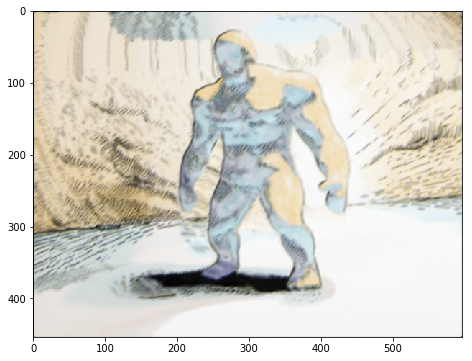

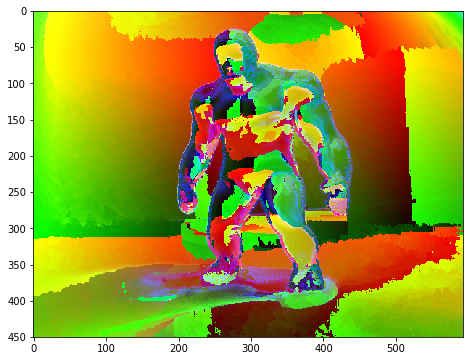

CPU times: user 21.4 s, sys: 622 ms, total: 22 s
Wall time: 21.1 s


In [4]:
%%time
from patchmatch import nnf_approx

def nnf_shape(A,B,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    return (h_nnf,w_nnf,3)

# first level
l = 0
patch_size = 5
iterations = 10
mu1 = 0.0
mu2 = 1.0
nnf_initialized = False
reconstruct = True
nnf = np.zeros(nnf_shape( B_gp[l], A_gp[l], patch_size ))
rec = nnf_approx( B_gp[l], A_gp[l], nnf, patch_size, iterations, mu1, mu2, nnf_initialized, reconstruct )
show_img(rec[:,:,:3])
show_img(nnf)




In [1]:
def inversed_rec(S,T,nnf_ST):
    h,w,c = nnf_ST.shape
    rec_shape = T.shape
    rec_shape[2] += 1
    dim_of_max = rec_shape[2]
    rec = np.zeros(rec_shape)
    for i in range(h):
        for j in range(w):
            nnf_i,nnf_j,dist_ = nnf()
            
    

(227, 299, 18)
(227, 299, 18)
(227, 299, 18)


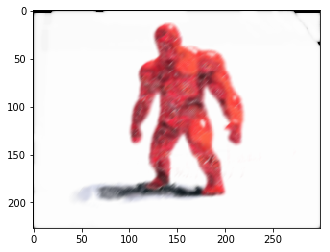

(227, 299, 18)
(454, 597, 18)


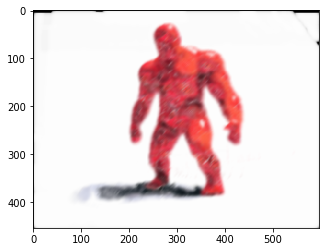

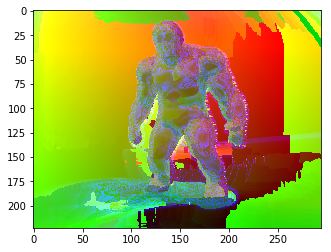

In [24]:
print(rec.shape)
print(B_gp[l].shape)
print(A_gp[l].shape)
show_img(rec[:,:,:3])
print (rec.shape)
print (B_gp[l-1].shape)
h1,w1,c=B_gp[l-1].shape
recnext = resize_to(rec[:,:,:],[h1,w1,c])
show_img(recnext[:,:,:3])
show_img(nnf)


In [ ]:
def nnf_shape(A,B,patch_size):
    h,w = A.shape[0:2]
    h_nnf = h-patch_size//2*2
    w_nnf = w-patch_size//2*2
    return (h_nnf,w_nnf,3)

def multi_scale_pait(B_gp,A_gp,patch_size):
    first_layer = len(B_gp) - 1
    # fixed number given by the authors of patch match
    iterations = 5
    # For the first layer do not use the style information.
    l, mu1, mu2, nnf_initialized = first_layer, 0.0, 1.0, False
    nnf = np.zeros(nnf_shape(B_gp[l],A_gp[l],patch_size))
    rec = nnf_approx( B_gp[l], A_gp[l], nnf, 
                      patch_size, iterations, 
                      mu1, mu2, nnf_initialized )
    # Intermediate layers
    mu1, mu2, nnf_initialized = 1.0, 2.0, True
    # E-M like iterations
    for l in range(l-1,0):
        # rescale nnf for the next layer (good initliaziation)
        nnf_shape = nnf_shape(B_gp[l],A_gp[l],patch_size)
        nnf = resize_to(nnf,nnf_shape)
        # rescale reconstruction (E step)
        rec = resize_to(rec,B_gp[l].shape)
        B_gp[l][:,:,:3] = rec[:,:,:3]
        rec = nnf_approx( B_gp[l], A_gp[l], nnf, 
                      patch_size, iterations, 
                      mu1, mu2, nnf_initialized )
    return rec
        
        

(227, 299, 18)
(227, 299, 18)
(227, 299, 18)


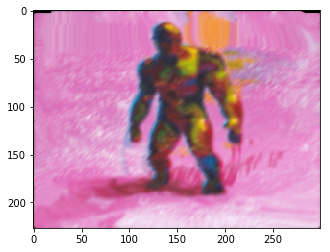

In [15]:
print(rec.shape)
print(B_gp[l].shape)
print(A_gp[l].shape)
show_img(rec[:,:,:3])

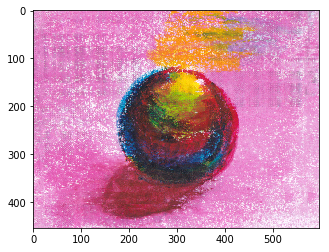

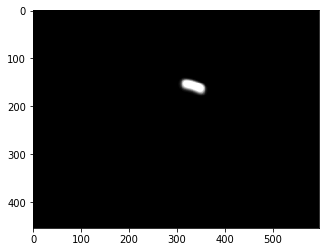

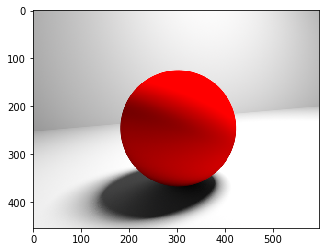

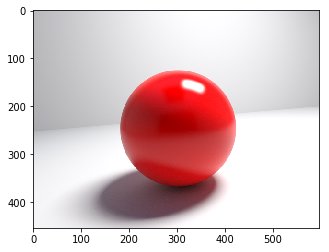

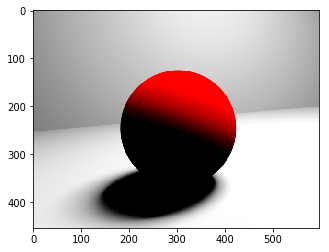

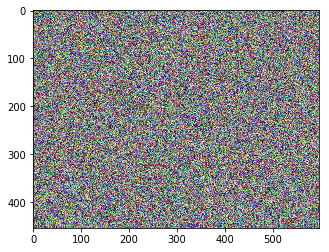

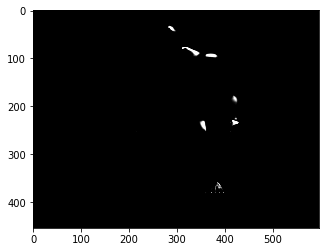

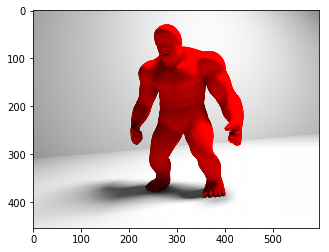

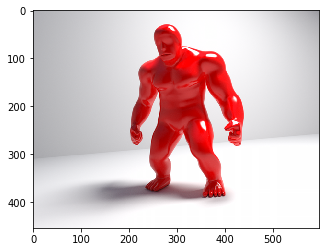

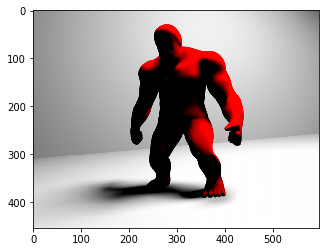

In [16]:
show_img(A[:,:,0:3])
show_img(A[:,:,3:6])
show_img(A[:,:,6:9])
show_img(A[:,:,9:12])
show_img(A[:,:,12:15])

show_img(B[:,:,0:3])
show_img(B[:,:,3:6])
show_img(B[:,:,6:9])
show_img(B[:,:,9:12])
show_img(B[:,:,12:15])

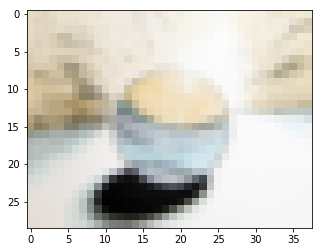

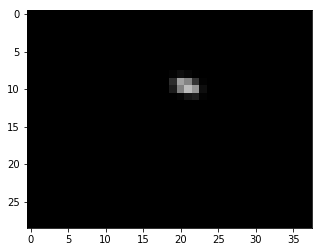

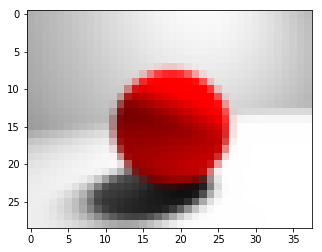

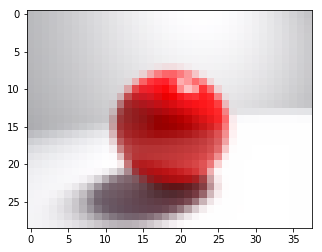

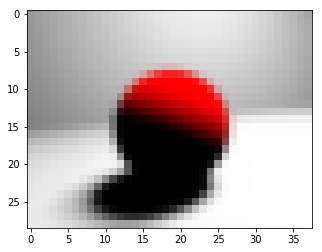

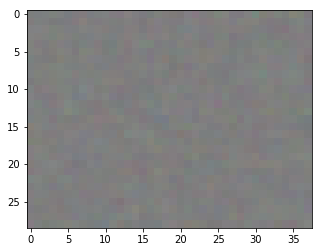

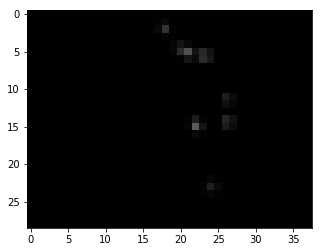

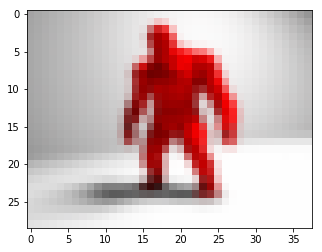

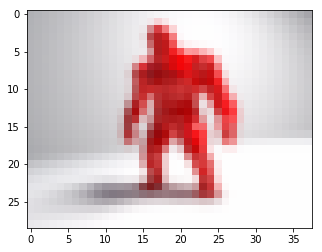

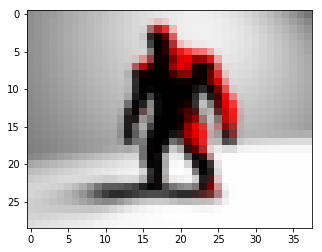

In [4]:
l = 4

show_img(A_gp[l][:,:,0:3])
show_img(A_gp[l][:,:,3:6])
show_img(A_gp[l][:,:,6:9])
show_img(A_gp[l][:,:,9:12])
show_img(A_gp[l][:,:,12:15])

show_img(B_gp[l][:,:,0:3])
show_img(B_gp[l][:,:,3:6])
show_img(B_gp[l][:,:,6:9])
show_img(B_gp[l][:,:,9:12])
show_img(B_gp[l][:,:,12:15])

In [15]:
!make

c++ -O3 -Wall -shared -std=c++11 -fPIC `python3 -m pybind11 --includes` patchmatch.cpp -o patchmatch`python3-config --extension-suffix`
patchmatch.cpp: In function ‘float style_ssd(pybind11::array_t<double>, pybind11::array_t<double>, int, int, int, int, int)’:
patchmatch.cpp:29:28: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
   for ( size_t offx=0; offx<w; offx++ )
                            ^
patchmatch.cpp:30:30: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
     for ( size_t offy=0; offy<w; offy++ ) {
                              ^
patchmatch.cpp: In function ‘void initialization(pybind11::array_t<double>, pybind11::array_t<double>, pybind11::array_t<double>, int)’:
patchmatch.cpp:51:21: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
   for (size_t i=0; i<nnf_h; i++)
                     ^
patchmatch.cpp:52:23: warning: comparison between signed and unsigned integ

In [ ]:
import pypatchmatch

def ssd(patch1, patch2):
    return np.sum((patch1-patch2)**2)

def asymetric_ssd2(a,b,mu1=1.0,mu2=2.0):
    a_style, b_style = a[:,:,0:3],b[:,:,0:3]
    a_lpe, b_lpe = a[:,:,3:18],b[:,:,3:18]
    diff1 = ssd(a_style,b_style)
    return mu1*diff1 + mu2*ssd(a_lpe, b_lpe)

def asymetric_ssd(a,b,mu1=0.0,mu2=2.0):
    ah,aw = a.shape[:2]
    bh,bw = b.shape[:2]
    diff1 = 0.0
    diff2 = 0.0
    for i in range(ah):
        for j in range(aw):
            for c in range(3):
                diff1 += (a[i,j,c] - b[i,j,c])**2
            for c in range(3,18):
                diff2 += (a[i,j,c] - b[i,j,c])**2
    return (diff1*mu1) + (diff2*mu2)
 
# Wexler 2007
l = 0
default_w = 5
pB = B_gp[l][10:10+default_w,10:10+default_w,:]
pA = A_gp[l][10:10+default_w,10:10+default_w,:]
print(asymetric_ssd(pB,pA))
print(asymetric_ssd2(pB,pA))

nnf = pypatchmatch.nnf_approx(B_gp[l],A_gp[l],distance_function=asymetric_ssd2,patch_size=default_w)
#nnf = pypatchmatch.nnf_approx(B_gp[l],A_gp[l],patch_size=default_w)

0.804367550942
15.7939254133
initilaization


In [11]:
import pypatchmatch


In [8]:
a_style = A_gp[l][:,:,:3]
b_style = B_gp[l][:,:,:3]
rec = pypatchmatch.reconstruction(b_style,a_style,nnf,5)

In [1]:
show_img(rec)
print(np.max(A_gp[l]))

NameError: name 'show_img' is not defined

In [13]:
# Wexler 2007
l = 0
default_w = 5
nnfssd = pypatchmatch.nnf_approx(B_gp[l],A_gp[l],patch_size=default_w)

initilaization
==========iteration 1/5 ==========
==========iteration 2/5 ==========
==========iteration 3/5 ==========
==========iteration 4/5 ==========
==========iteration 5/5 ==========
